## Implementing "An Approach for objective quality assessment of image inpainting results" 


### General Setup

In [11]:
import cv2 as cv
import numpy as np
import math
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
import pandas as pd

In [3]:
original = '../COTSDataset-master/Part 2 - Multiple Objects/wash_no/2_colour.jpeg'
mask = '../COTSDataset-master/Part 2 - Multiple Objects/wash_no/masks/wash_no_3_colour_mask_5_mask.png'

img = cv.imread(original)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

mask = cv.imread(mask)
mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)


### Inpainting with Telea

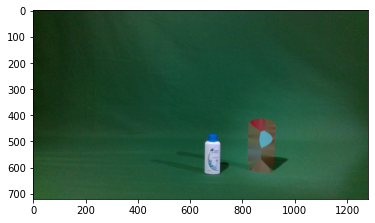

In [4]:
inpaintedImage = cv.inpaint(img, mask, 3, cv.INPAINT_TELEA)
plt.imshow(inpaintedImage)
plt.show()

### Inpainting with NS

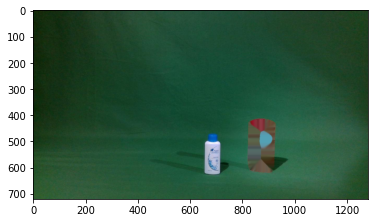

In [5]:
inpaintedImage = cv.inpaint(img, mask, 3, cv.INPAINT_NS)
plt.imshow(inpaintedImage)
plt.show()

### Evaluating Inpainting

In [6]:
def CompareResult(inpaintedImage, groundTruth, metric):
     if metric == 1:
        return PSNR(inpaintedImage, groundTruth) #PSNR
     elif metric == 2:
        return MSE(inpaintedImage, groundTruth) #MSE
     else:
         return SSIM(inpaintedImage, groundTruth)[0] #SSIM
      

In [7]:
def MSE(inpaintedImage, groundTruth):
    return np.mean((inpaintedImage - groundTruth) ** 2)

In [8]:
def PSNR(inpaintedImage, groundTruth):
    mse = MSE(inpaintedImage, groundTruth)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    return 20 * math.log10(max_pixel / math.sqrt(mse))

In [12]:
def SSIM(inpaintedImage, groundTruth):
    grayA = cv.cvtColor(inpaintedImage, cv.COLOR_RGB2GRAY)
    grayB = cv.cvtColor(groundTruth, cv.COLOR_RGB2GRAY)
    score, diff = compare_ssim(grayA, grayB, full=True) 
    diff = (diff * 255).astype("uint8")
    return score, diff


In [13]:
original = '../COTSDataset-master/Part 2 - Multiple Objects/wash_no/1_colour.jpeg'
groundTruth = cv.imread(original)
groundTruth = cv.cvtColor(groundTruth, cv.COLOR_BGR2RGB)

error = CompareResult(inpaintedImage, groundTruth, 1)
print("PSNR: ", error)   

error = CompareResult(inpaintedImage, groundTruth, 2)
print("MSE: ", error) 

error = CompareResult(inpaintedImage, groundTruth, 3)
print("SSIM: ", error)   

PSNR:  36.56346980979196
MSE:  14.346084346064815
SSIM:  0.910350215670903


### Larger Testing Space

In [19]:
def performEvaluation(groundTruth, img, mask):
    inpaintedImageNS = cv.inpaint(img, mask, 3, cv.INPAINT_NS)
    inpaintedImageTelea = cv.inpaint(img, mask, 3, cv.INPAINT_TELEA)

    f, axarr = plt.subplots(1, 5, figsize = (30, 20))
    axarr[0].imshow(img)
    axarr[1].imshow(mask, cmap='gray')
    axarr[2].imshow(groundTruth)
    axarr[3].imshow(inpaintedImageTelea)
    axarr[4].imshow(inpaintedImageNS)

    return CompareResult(inpaintedImageNS, img, 2), CompareResult(inpaintedImageTelea, img, 2)


In [33]:
def evaluateMatrix(base, images, imgLoc, baseLoc, maskLoc):
    columns = ["Image", "Occulusion", "Telea", "NS", "Max Error"]
    results = pd.DataFrame(columns = columns)

    for x in range(0, len(images)):
        img = cv.imread(base + images[x] + imgLoc[x])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        base2 = cv.imread(base + images[x] + baseLoc[x])
        base2 = cv.cvtColor(base2, cv.COLOR_BGR2RGB)
        mask = cv.imread(base + images[x] + maskLoc[x])
        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
        resultNS, resultTelea = performEvaluation(img, base2, mask)
        results = results.append({'Image':images[x], 'Occulusion':"No", 'Telea':resultTelea, 'NS':resultNS, 'Max Error':"NA"}, ignore_index = True)
    
    return results


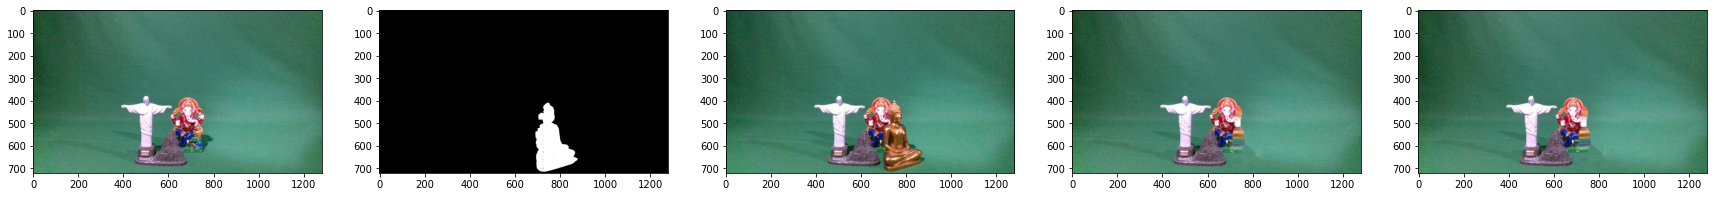

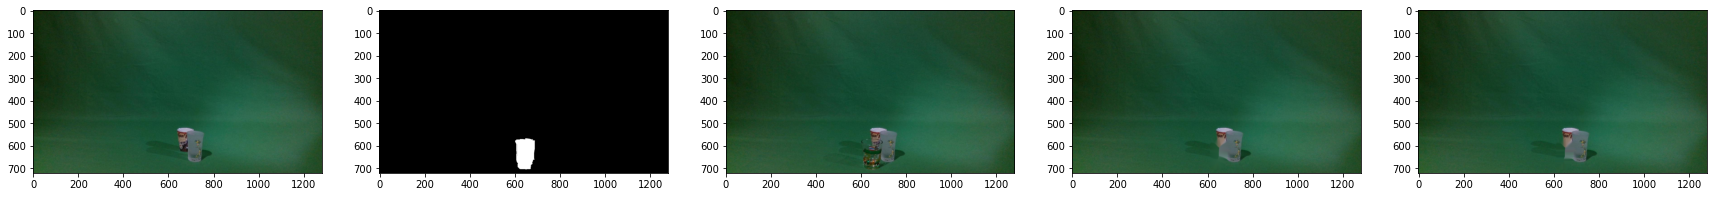

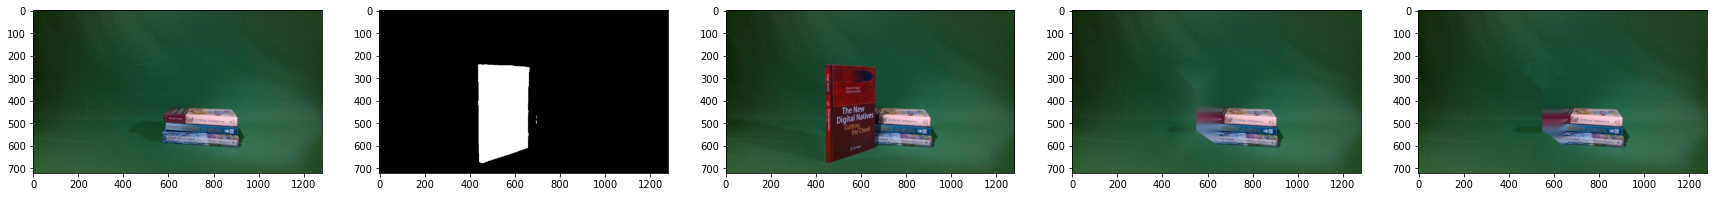

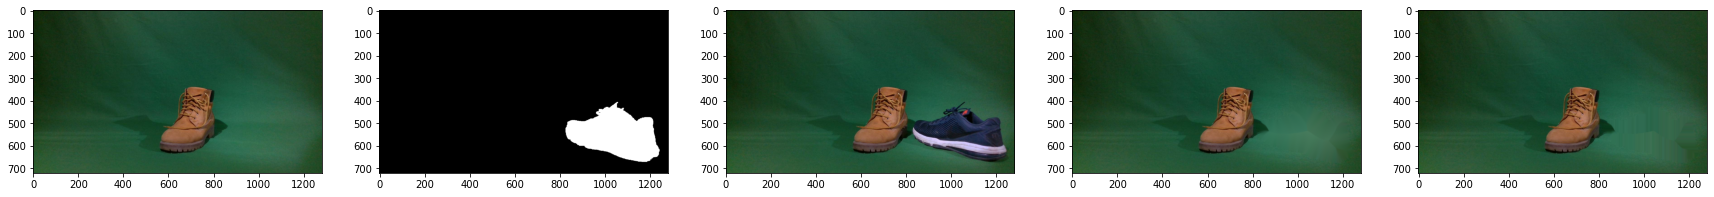

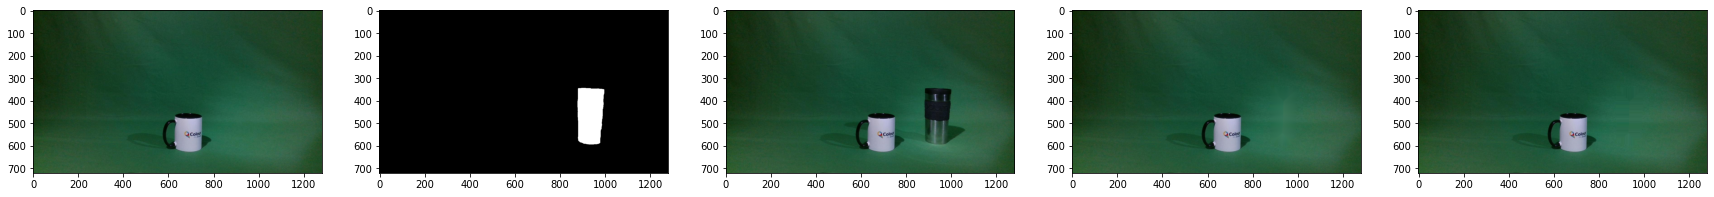

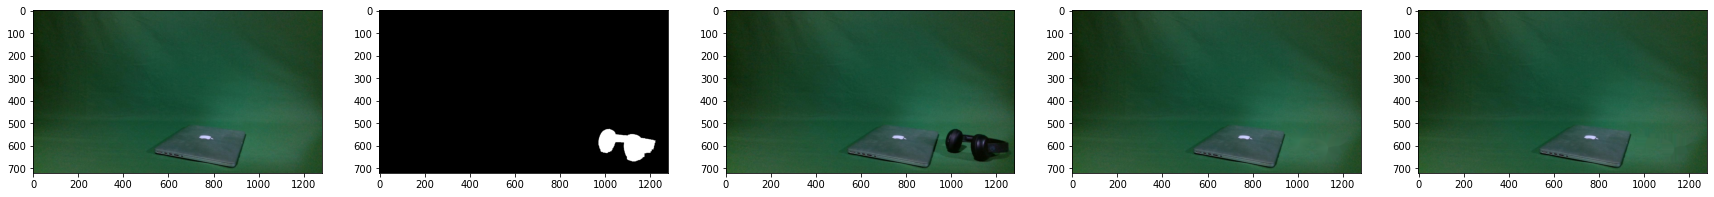

In [34]:
base = "../COTSDataset-master/Part 2 - Multiple Objects/"
images = ["statues_oc", "shooters_oc", "academic_book_oc", "footwear_no", "mugs_no", "tech_no"]
imgLoc = ['/3_colour.jpeg', '/3_colour.jpeg', '/2_colour.jpeg', '/2_colour.jpeg', '/2_colour.jpeg', '/2_colour.jpeg']
baseLoc = ['/2_colour.jpeg', '/2_colour.jpeg', '/1_colour.jpeg', '/1_colour.jpeg', '/1_colour.jpeg', '/1_colour.jpeg']
maskLoc = ['/masks/statues_oc_3_colour_mask_5_mask.png', 
           '/masks/shooters_oc_3_colour_mask_0_mask.png',
           '/masks/ac_oc_3_colour_mask_5_mask.png', 
           '/masks/footware_no_3_colour_mask_2_mask.png', 
           '/masks/3_colour_mask_2_mask.png', 
           '/masks/tech_no_3_colour_mask_2_mask.png']

results = evaluateMatrix(base, images, imgLoc, baseLoc, maskLoc)


### Evaluation Matrix

In [36]:
results

,Image,Occulusion,Telea,NS,Max Error
0,statues_oc,No,2.008133,1.916529,NA
1,shooters_oc,No,0.537624,0.520488,NA
2,academic_book_oc,No,6.528118,3.308492,NA
3,footwear_no,No,3.738643,1.982491,NA
4,mugs_no,No,0.633741,0.274197,NA
5,tech_no,No,0.340032,0.322878,NA


### Target Object Size

In [30]:
def targetObjectSize(mask):
    height = mask.shape[0]
    width = mask.shape[1]
    white = 0
    black = height*width

    for y in range(0, height): 
	    for x in range(0, width):
                if mask[y, x] > 0:
                    white += 1

    black

    return (white/black)*100

In [31]:
columns = ["Image", "Target Object Size %"]
size = pd.DataFrame(columns = columns)

masks = ["statues_oc/masks/statues_oc_3_colour_mask_5_mask.png", 
         "shooters_oc/masks/shooters_oc_3_colour_mask_0_mask.png", 
         "academic_book_oc/masks/ac_oc_3_colour_mask_5_mask.png", 
         "footwear_no/masks/footware_no_3_colour_mask_2_mask.png", 
         "mugs_no/masks/3_colour_mask_2_mask.png", 
         "tech_no/masks/tech_no_3_colour_mask_2_mask.png"]

base = "../COTSDataset-master/Part 2 - Multiple Objects/"

images = ["statues_oc", "shooters_oc", "academic_book_oc", "footwear_no", "mugs_no", "tech_no"]

for x in range(0, len(masks)):
    temp = cv.imread(base+(masks[x]))
    temp = cv.cvtColor(temp, cv.COLOR_BGR2GRAY)
    white = targetObjectSize(temp)
    size = size.append({'Image':images[x], 'Target Object Size %':white}, ignore_index = True)

size = size.append({'Image':'Average', 'Target Object Size %':size['Target Object Size %'].mean()}, ignore_index = True)

In [32]:
size

,Image,Target Object Size %
0,statues_oc,3.339084
1,shooters_oc,1.082791
2,academic_book_oc,9.610135
3,footwear_no,7.213867
4,mugs_no,2.872938
5,tech_no,2.134657
6,Average,4.375579


### Evaluation with Complex Backgrounds

In [25]:

baseMask = '../COTSDataset-master/Part 3 - Complex Background/masks/'
baseMaskImg = ["/1_colour.png", "/3_colour.png", "/1_colour.png", "/3_colour.png", "/1_colour.png", "/3_colour.png"]
images = ["booksA_nw_no", "booksA_w_no", "bottlesA_nw_no", "bottlesA_w_no", "cupsA_w_no", "cupsA_nw_no"]

loadedImages = []

for x in range(0, len(images)):
    loadedImages.append(cv.imread(baseMask+images[x]+baseMaskImg[x]))
    loadedImages[x] = cv.cvtColor(loadedImages[x], cv.COLOR_BGR2GRAY)



getting colour values form masks

In [26]:
for img in range(0, len(loadedImages)):
    unique = []
    for y in loadedImages[img]:
        for x in y:
            if x not in unique:
                unique.append(x)
    print("Image", img, ": ", unique)


Image 0 :  [0, 113, 15, 75, 38]
Image 1 :  [0, 113, 38, 15, 75]
Image 2 :  [0, 38, 113, 75]
Image 3 :  [0, 38, 75]
Image 4 :  [0, 38, 75, 113]
Image 5 :  [0, 75, 113, 38]


Creating masks

0
1
2
3
4
5


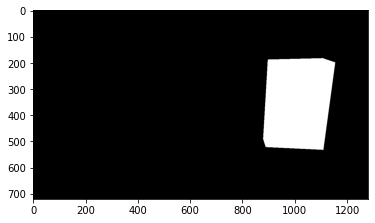

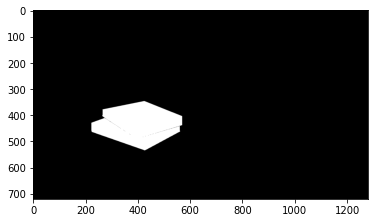

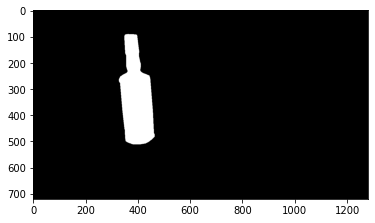

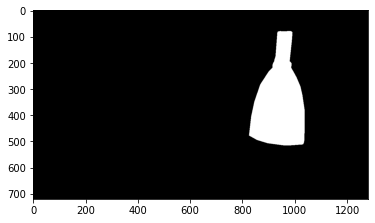

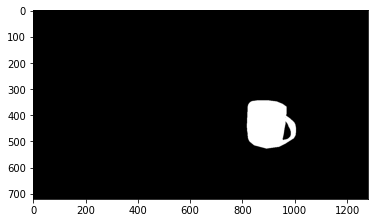

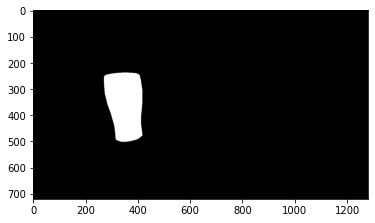

In [27]:
masks = []
maskedObjects = [[15], [15, 75], [75], [75], [113], [113], [75], [113]]

for img in range(0, len(loadedImages)):
    tempImg = loadedImages[img].copy()
    for y in range(0, len(loadedImages[img])):
        for x in range(0, len(loadedImages[img][y])):
            if loadedImages[img][y][x] in maskedObjects[img]:
                tempImg[y, x] = 255
            else:
                tempImg[y, x] = 0
    masks.append(tempImg)

for x in masks:
    plt.figure()
    plt.imshow(x, cmap='gray')
    


0
1
2
3
4
5


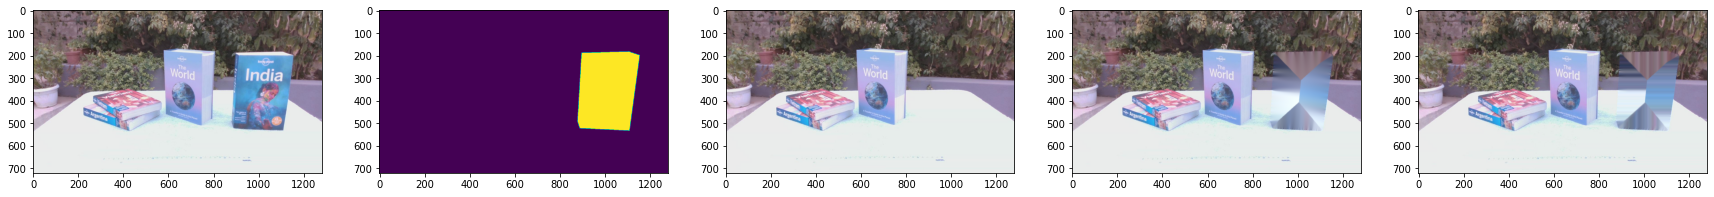

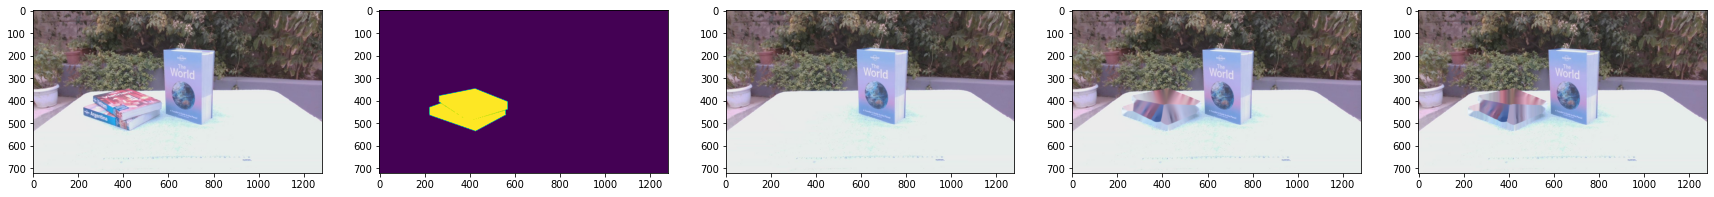

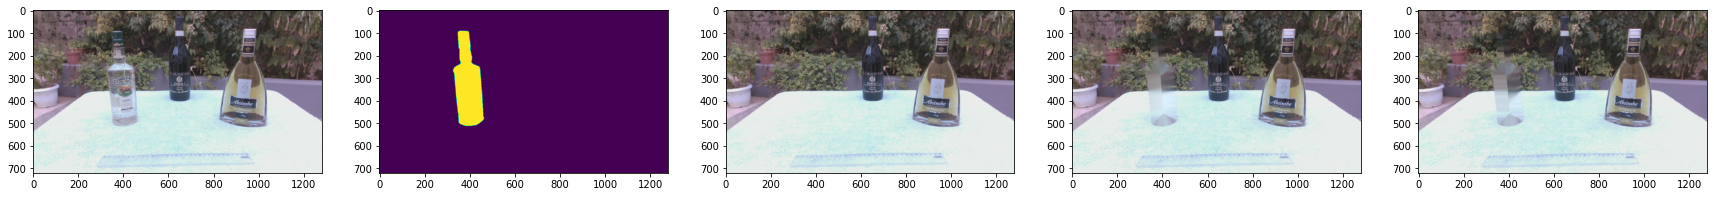

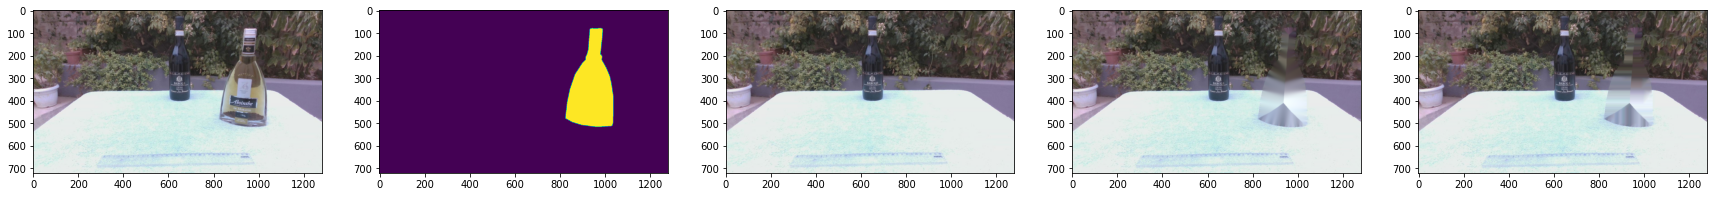

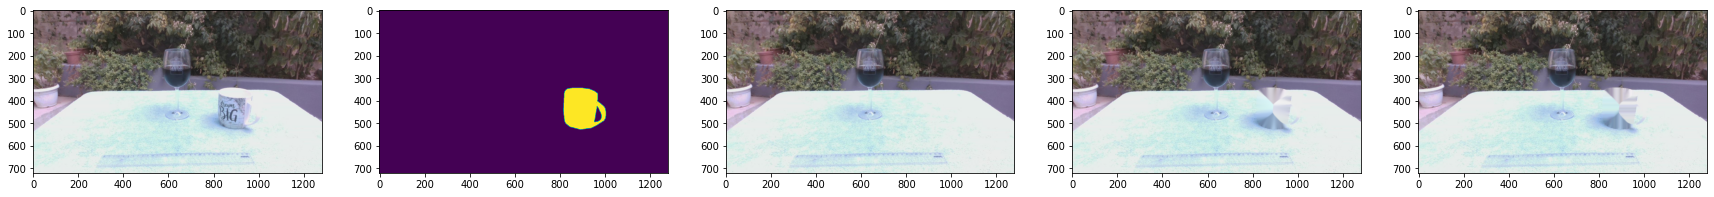

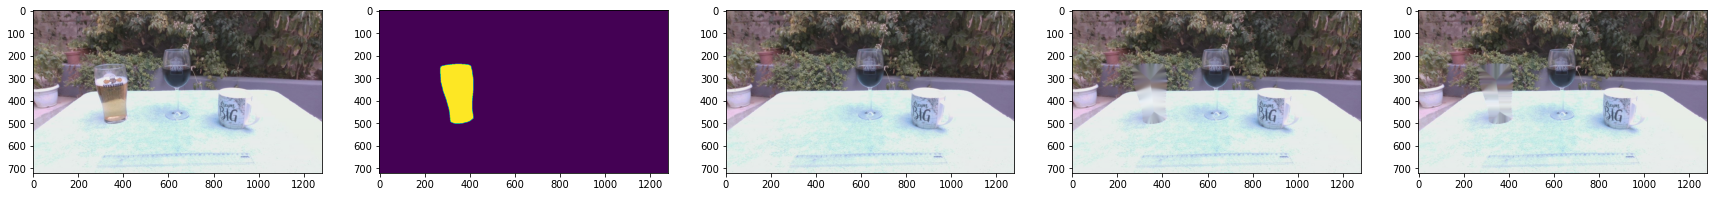

In [28]:
base = "../COTSDataset-master/Part 3 - Complex Background/"
imgLoc = ["/1_colour.jpeg", "/2_colour.jpeg", "/1_colour.jpeg", "/3_colour.jpeg", "/2_colour.jpeg", "/3_colour.jpeg"]
baseLoc = ["/2_colour.jpeg", "/1_colour.jpeg", "/2_colour.jpeg", "/2_colour.jpeg", "/3_colour.jpeg", "/2_colour.jpeg"]

columns = ["Image", "Occulusion", "Ours+Telea", "Ours+NS", "Max Error"]
results2 = pd.DataFrame(columns = columns)

for x in range(0, len(images)):
    print(x)
    img = cv.imread(base + images[x] + imgLoc[x])
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    base2 = cv.imread(base + images[x] + baseLoc[x])
    base2 = cv.cvtColor(base2, cv.COLOR_BGR2RGB)
    mask = masks[x]
    resultNS, resultTelea = performEvaluation(base2, img, mask)
    results2 = results2.append({'Image':images[x], 'Occulusion':"yes", 'Ours+Telea':resultTelea, 'Ours+NS':resultNS, 'Max Error':"NA"}, ignore_index = True)

In [29]:
results2

,Image,Occulusion,Ours+Telea,Ours+NS,Max Error
0,booksA_nw_no,yes,9.556629,9.635998,NA
1,booksA_w_no,yes,4.715893,4.810172,NA
2,bottlesA_nw_no,yes,4.276392,4.139265,NA
3,bottlesA_w_no,yes,6.751261,6.707058,NA
4,cupsA_w_no,yes,2.713670,2.710043,NA
5,cupsA_nw_no,yes,3.615135,3.617102,NA


In [30]:
columns = ["Image", "Target Object Size"]
size2 = pd.DataFrame(columns = columns)

for x in range(0, len(masks)):
    print(x)
    white = targetObjectSize(masks[x])
    size2 = size2.append({'Image':images[x], 'Target Object Size':white}, ignore_index = True)

size2 = size2.append({'Image':'Average', 'Target Object Size':size2['Target Object Size'].mean()}, ignore_index = True)

0
1
2
3
4
5


In [31]:
size2

,Image,Target Object Size
0,booksA_nw_no,9.074653
1,booksA_w_no,4.599392
2,bottlesA_nw_no,4.128581
3,bottlesA_w_no,6.416233
4,cupsA_w_no,2.905273
5,cupsA_nw_no,3.453559
6,Average,5.096282


### Background Subtraction

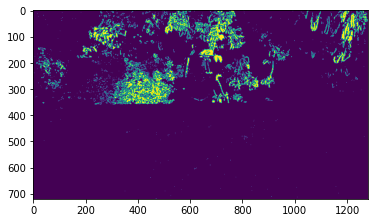

In [32]:
imgWithWind = cv.imread(base + "cupsA_nw_no/2_colour.jpeg")
imgWithNoWind = cv.imread(base + "cupsA_w_no/2_colour.jpeg")

imgWithWind = cv.cvtColor(imgWithWind, cv.COLOR_BGR2GRAY)
imgWithNoWind = cv.cvtColor(imgWithNoWind, cv.COLOR_BGR2GRAY)

background_object = cv.createBackgroundSubtractorMOG2()
sharp_img = background_object.apply(imgWithWind)
sharp_img = background_object.apply(imgWithNoWind)

plt.imshow(sharp_img)
